# Tournament Structure

In this notebook we will learn about the structure of the tournament. Think of this as the official rules of the game.   

1. Rounds: the lifecyle and schedule of live tournament rounds
2. Submissions: submission window, late & queued submissions
3. Scoring: daily score estimates, submission vs model scores  
4. Staking: at-risk, 
5. Payouts: payout function, , payout factor, compounding, return 

## 1. Rounds

The live tournament is organized into daily `rounds` that happen 5x a week.

Lifecyle of a `round`:
- `open`: when a new era of live features are released
- `close`: the submission deadline for live predictions 
- `score` when scoring will begin and update daily
- `resolve` when scoring will end and payouts/burns resolved

Let's take a look at some recent rounds as an example.

In [218]:
from numerapi import NumerAPI 
import pandas as pd
napi = NumerAPI()
rounds = pd.DataFrame(napi.raw_query('''
    query {
        rounds(tournament: 8, limit: 25) {
            number
            open: openTime
            close: closeStakingTime
            score: scoreTime  
            resolve: resolveTime
        }
    }
''')["data"]["rounds"]).set_index("number")[["open", "close", "score", "resolve"]].sort_values("number")
# Convert all columns to datetime types 
for col in rounds.columns:
    rounds[col] = pd.to_datetime(rounds[col])
rounds.head()

,open,close,score,resolve
number,,,,
449,2023-03-25 15:08:40+00:00,2023-03-27 14:00:40+00:00,2023-03-31 15:30:40+00:00,2023-04-27 20:00:40+00:00
450,2023-03-28 13:09:50+00:00,2023-03-28 14:09:50+00:00,2023-04-01 15:30:50+00:00,2023-04-28 20:00:50+00:00
451,2023-03-29 13:00:00+00:00,2023-03-29 17:00:00+00:00,2023-04-04 15:30:00+00:00,2023-04-29 20:00:00+00:00
452,2023-03-30 13:00:00+00:00,2023-03-30 16:00:00+00:00,2023-04-05 15:30:00+00:00,2023-05-02 20:00:00+00:00
453,2023-03-31 13:00:00+00:00,2023-03-31 14:00:00+00:00,2023-04-06 15:30:00+00:00,2023-05-03 20:00:00+00:00


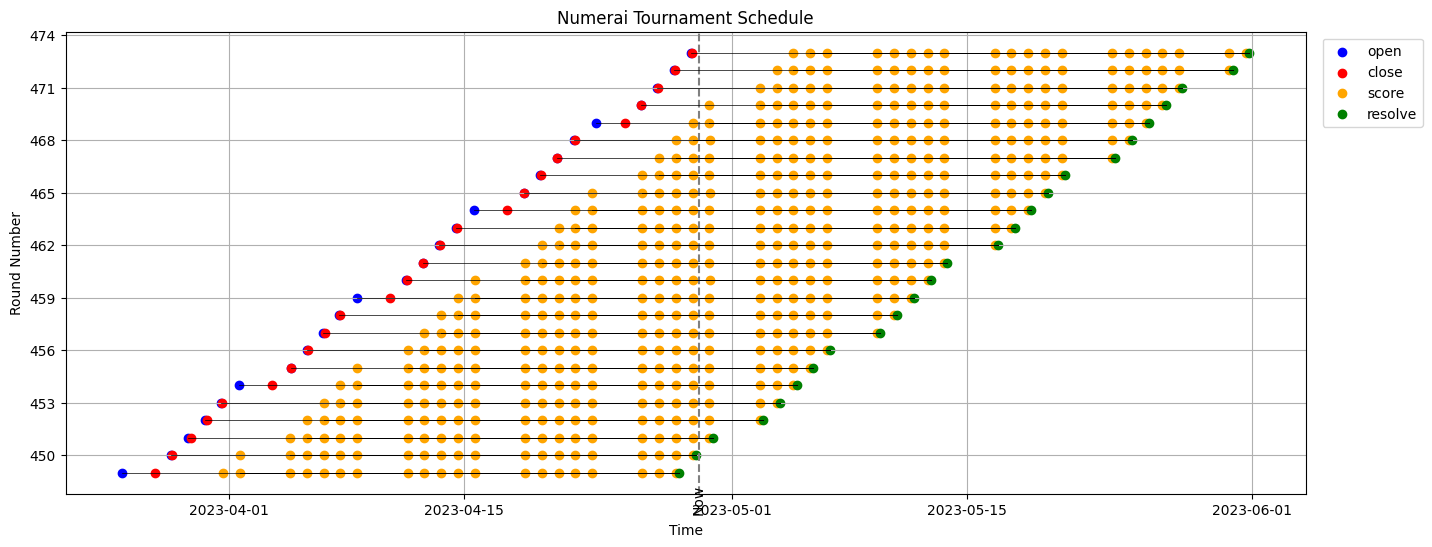

In [219]:
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
import pytz

# transform into timestamp/events shape for easier plotting
events = rounds.stack().reset_index().rename(columns={"level_1": "event", 0: "time"})

# add events for "daily score updates" (not returned by the API)
new_rows = []
for _, row in events[events['event'] == 'score'].iterrows():
    new_rows.extend(
        {'number': row['number'], 'event': 'score', 'time': row['time'] + dt.timedelta(days=i)}
        for i in range(1, 28) if (row['time'] + dt.timedelta(days=i)).weekday() not in [0, 6]
    )
events = pd.concat([events, pd.DataFrame(new_rows)], ignore_index=True)

# plot the events 
colors = {'open': 'blue', 'close': 'red', 'score': 'orange', 'resolve': 'green'}
fig, ax = plt.subplots(figsize=(16,6))
for event in events['event'].unique():
    ax.scatter(events[events['event'] == event]['time'], events[events['event'] == event]['number'], color=colors[event], label=event)

# add a vertical dotted line indicating the current UTC time
now = dt.datetime.utcnow().replace(tzinfo=pytz.UTC)
xlim_dates = mdates.num2date(ax.get_xlim())
xlim_dates_tz = [d.replace(tzinfo=pytz.UTC) for d in xlim_dates]
if now >= xlim_dates_tz[0] and now <= xlim_dates_tz[1]:
    ax.axvline(x=now, linestyle='--', color='gray')
    label = ax.text(x=now, y=events['number'].min() - 1.5, s='Now', ha='center', va='center')
    label.set_rotation(90)

# connect all points with the same round number with a less bold black line
for rnd in events['number'].unique():
    rnd_events = events[events['number'] == rnd]
    if len(rnd_events) > 1:
        ax.plot(rnd_events['time'], rnd_events['number'], color='black', linewidth=0.5)

# formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
ax.grid()
plt.xlabel('Time')
plt.ylabel('Round Number')
plt.title('Numerai Tournament Schedule')
plt.show()

The above chart is a visualization of the schedule of the recent live tournament rounds:
- Every horitontal line is a `round` 
- Each round consists of `open`, `close`, `score` and `resolve` events 
- The lifecyle of a round is `open` (blue) --> `close` (red)--> 20x `score` (yellow) --> `resolve` (green)

Weekend vs weekday rounds:
- Weekend rounds `open` on Saturday and `close` on Monday, which are the rows where the blue and red dots are wide apart.
- Weekday rounds `open` and `close` on the same day, which are the rows where the blue dot is barely visible because of the overlap with the red dot.

A few more observations:
- At any given time, like right now indicated by the veritical dotted line, there will be many ongoing rounds which are all the horizontal lines that intersect with the veritical dotted line.
- The 20 day returns used to compute live targets correspond to the 20 scoring days. On each day, Numerai is able to compute an estimate of the target value based on an expanding window of days of returns.
- There are two days, Sunday and Monday, where not much happens on Numerai with respect to these live rounds. These two days correspond to the weekend in the live stock market but offset because of data processing delays.
- The overlap of live tournament eras are just like the overlap of eras in the training and validation dataset, except that live eras are only 1 day instead of 1 week apart!

## Submissions

In order for your live submission to be counted in a round, it must be submitted during the `submission window` between the `open` and `close` time of a round. 

Let's take a look at some recent rounds to get a sense of their schedule.

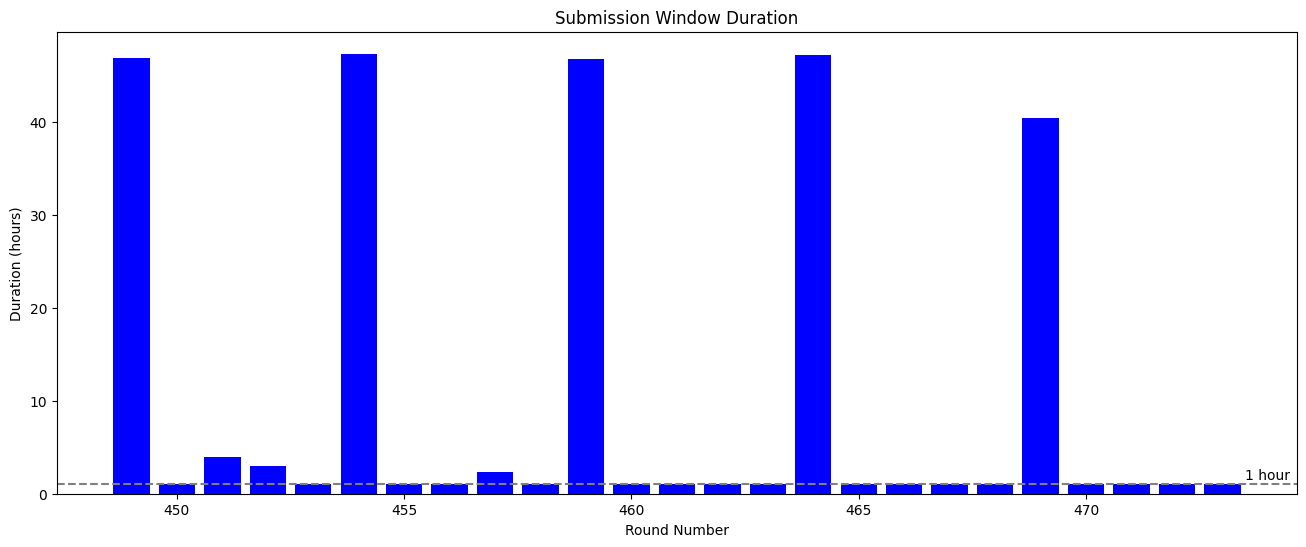

In [220]:
# add a new column submission window duration
rounds['duration'] = rounds['close'] - rounds['open']

# plot the duration in hours for eah round
fig, ax = plt.subplots(figsize=(16,6))
ax.bar(rounds.index, rounds['duration'].dt.total_seconds() / 3600, color='blue')
ax.set_title('Submission Window Duration')  
ax.set_xlabel('Round Number')
ax.set_ylabel('Duration (hours)')

# add a dotted line indicating the 1 hour minimum duration
ax.axhline(y=1, linestyle='--', color='gray')
label = ax.text(x=rounds.index.max() + 0.5, y=2, s='1 hour', ha='left', va='center')

Above is a chart of the submission windows of recent rounds.

As we can see, the submission windows for the weekend rounds are much longer than the weekday rounds. This is because we `open` the weekend round on Saturday and `close` on Monday. The weekday rounds, in contrast, open and close about 1 hour apart on the same day. Rounds generally `open` around the same time every day but sometimes the release of live features can be delayed. In these cases, we will extend the `close` time of the round to maintain at minimum a <ins>1-hour submission window</ins>.

If you submit after the `close` of a round, it will automatically be `queued` for submission at the `open` of the next round. You may submit as many times as you like for a round but only the latest submission will count for scoring and payouts.

## Scoring



There are two main scores
- `CORR` the correlation of your submission with the target 
- `TC`: the measure of your model's contribution to the hedge fund's live performance (see full explanation in our our [docs](https://docs.numer.ai/tournament/true-contribution-tc)) 

There are two dimensions to scores
- Over a single round, submissions will recieve a total of 20 score updates until the final scores are computed at `resolve`.
- Over many rounds, models will begin to establish a track record of live performance which only counts final scores. 

Let's take a look at both of these kinds of scores with an example model called [INTEGRATION_TEST](https://numer.ai/integration_test).

In [258]:
# Find the round that was last resolved 
last_resolved = int(rounds[rounds['resolve'] < pd.Timestamp.utcnow()].index.max())

# Query the API for the intra-round scores of the INTEGRATION_TEST model for the last resolved round
daily_scores = napi.raw_query('''
    query ($n: Int) {
        v2RoundModelPerformances(tournament: 8, roundNumber__eq: $n, modelId:"59de8728-38e5-45bd-a3d5-9d4ad649dd3f") {
            intraRoundSubmissionScores {
                displayName
                value
                date
            }
        }
    }
''', {"n": last_resolved})["data"]["v2RoundModelPerformances"][0]['intraRoundSubmissionScores']

# Pivot into dataframe where the displayName value is the header, and date is the index
daily_scores_df = pd.DataFrame(daily_scores).pivot(index='date', columns='displayName', values='value')[["v2_corr20", "tc"]]
daily_scores_df = daily_scores_df.rename(columns={"v2_corr20": "corr"})
daily_scores_df.columns.name = None
daily_scores_df

,corr,tc
date,,
2023-04-01T00:00:00Z,-0.081176,-0.011288
2023-04-04T00:00:00Z,-0.065102,-0.013496
2023-04-05T00:00:00Z,-0.058651,-0.016397
2023-04-06T00:00:00Z,-0.048741,-0.012283
2023-04-07T00:00:00Z,-0.066678,-0.004161
2023-04-08T00:00:00Z,-0.027599,-0.001819
2023-04-11T00:00:00Z,-0.041258,-0.002634
2023-04-12T00:00:00Z,-0.060257,-0.017271
2023-04-13T00:00:00Z,-0.073764,-0.012214


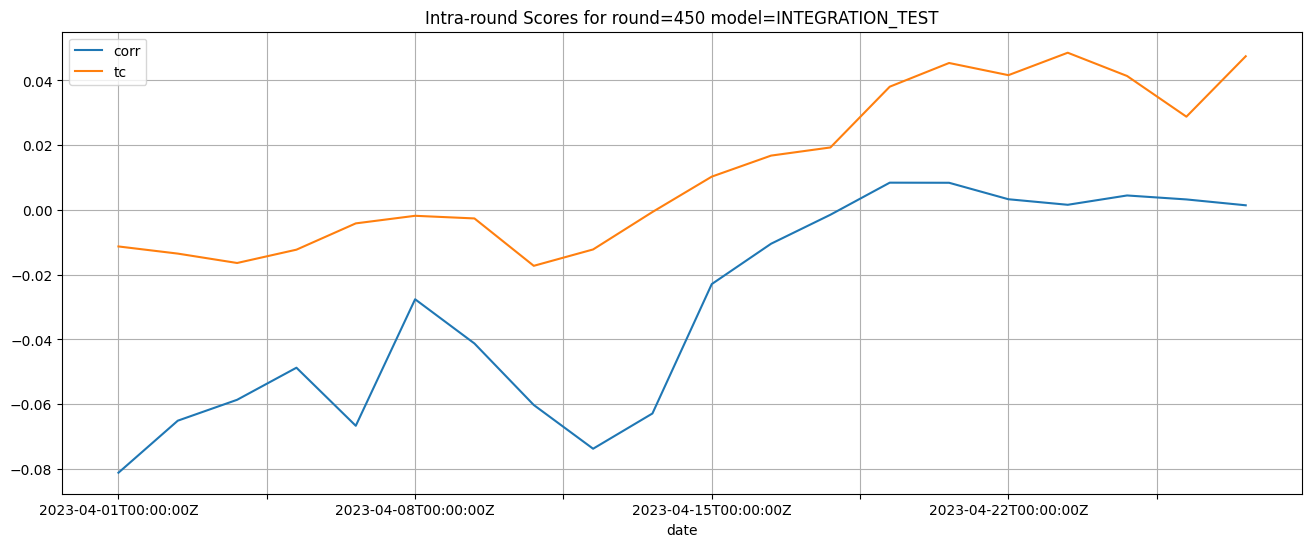

In [222]:
daily_scores_df.plot(figsize=(16,6), title=f'Intra-round Scores for round={last_resolved} model=INTEGRATION_TEST', grid=True);

The above chart shows the intra-round scores of a single submission during the scoring of a single round. 

The reason why scoring is done over these 20 days is because the target represents a 20 day return target. Each point on this chart represents an estimate of your final score based on returns of an expanding window of days. For example the 1st score is based on a 1 day return target all the way up to and the 20th score being based on a 20 day return target. But since scoring is officially done based on the 20 day return target, only the final 20th score is counted as the official score for the round.

It is important to note that since the targets are already based on expanding periods of return, these scores are already in essence cumulative. There is no sense in accumulating them over time again.

The bottom line is - daily score updates are informational and only the final score counts. Now let us turn our attention to these final scores.

In [302]:
# Query the API for the final scores of the INTEGRATION_TEST model
final_scores = napi.raw_query('''
    query {
        v2RoundModelPerformances(tournament: 8, modelId:"59de8728-38e5-45bd-a3d5-9d4ad649dd3f") {
            roundNumber
            roundResolved
            roundResolveTime
            submissionScores {
                displayName
                value
            }
        }
    }
''')["data"]["v2RoundModelPerformances"]

# filter out rounds that are not resolved
resolved_scores = [r for r in final_scores if r['roundResolved'] == True]
# convert the roundResolveTime to a datetime object
for r in resolved_scores:
    r['roundResolveTime'] = pd.to_datetime(r['roundResolveTime'])

# select all rounds resolved within 1 year from the latest resolved round
one_year = [r for r in resolved_scores if r['roundResolveTime'] > pd.Timestamp.utcnow() - pd.Timedelta(days=365)]

# for each item in list, iterate through the submissionScores and add a new key to top level for v2_corr20 and tc
for r in one_year:
    for s in r['submissionScores']:
        if s['displayName'] == 'v2_corr20':
            r['corr'] = s['value']
        elif s['displayName'] == 'tc':
            r['tc'] = s['value']
        
# convert to dataframe
final_scores_df = pd.DataFrame(one_year)[["roundNumber", "roundResolveTime", "corr", "tc"]]
final_scores_df

,roundNumber,roundResolveTime,corr,tc
0,450,2023-04-28 20:00:50+00:00,0.001427,0.047455
1,449,2023-04-27 20:00:40+00:00,-0.008276,0.003471
2,448,2023-04-26 20:00:36+00:00,0.002316,0.014453
3,447,2023-04-25 20:00:58+00:00,0.003700,-0.000975
4,446,2023-04-22 20:00:24+00:00,0.013802,0.014577
...,...,...,...,...
136,314,2022-06-02 20:00:00+00:00,0.020266,0.047216
137,313,2022-05-26 20:00:00+00:00,0.018232,0.093008
138,312,2022-05-19 20:00:00+00:00,0.026688,0.045579
139,311,2022-05-12 20:00:00+00:00,0.035044,0.063254


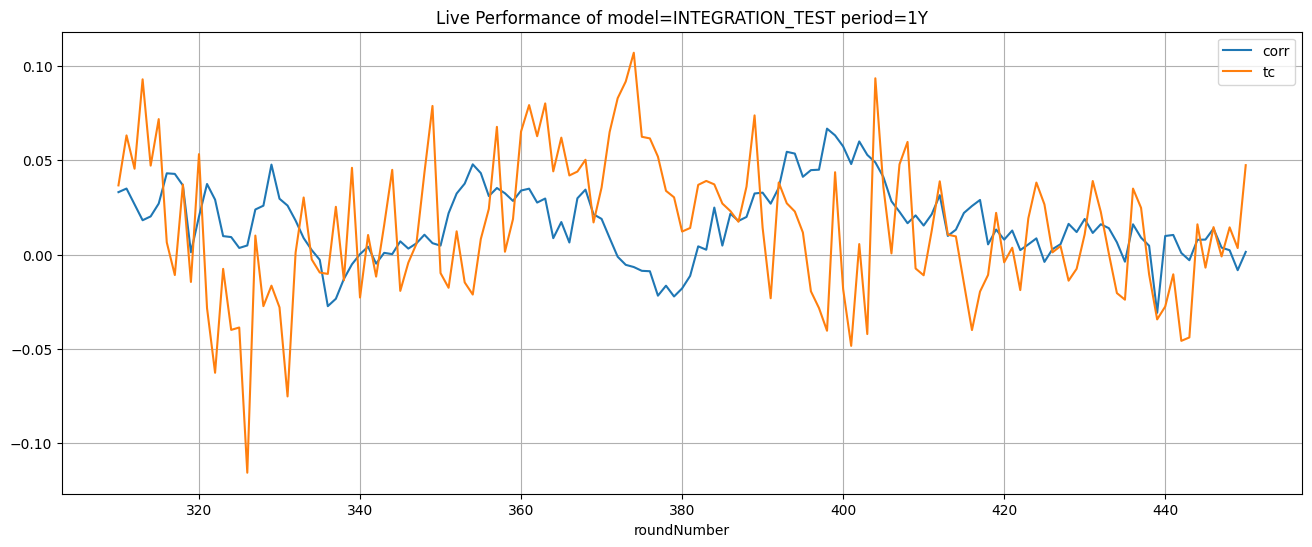

In [303]:
# Plot the per-round scores
final_scores_df.plot(x='roundNumber', y=['corr', 'tc'], figsize=(16,6), title='Live Performance of model=INTEGRATION_TEST period=1Y', grid=True);

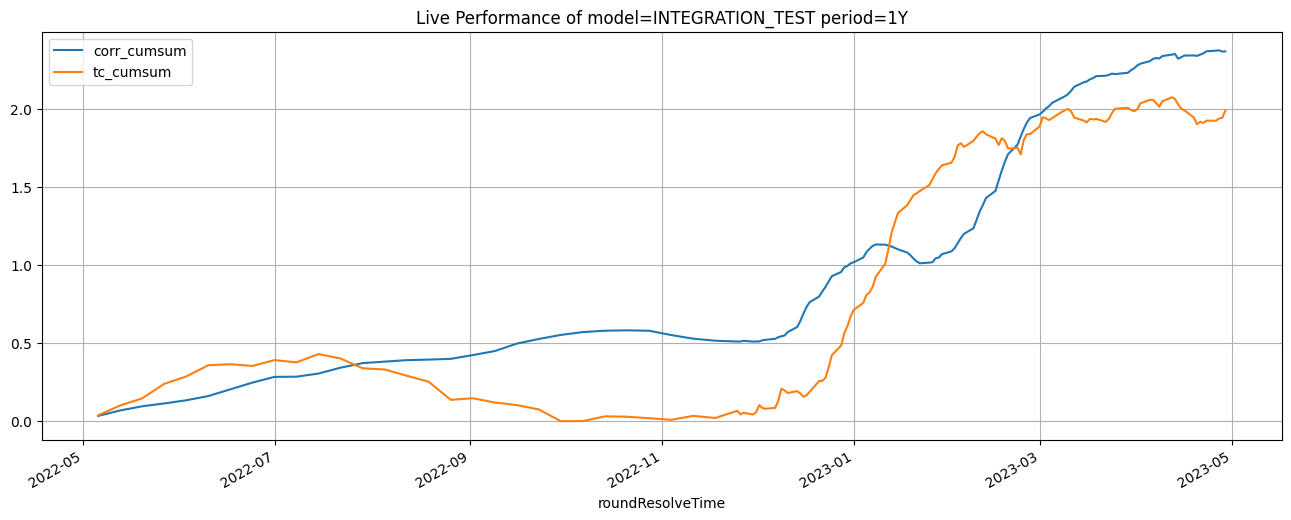

In [306]:
# plot cumulative scores, but using round resolve time as x-axis
final_scores_df['corr_cumsum'] = final_scores_df['corr'][::-1].cumsum()[::-1]
final_scores_df['tc_cumsum'] = final_scores_df['tc'][::-1].cumsum()[::-1]
final_scores_df.plot(x='roundResolveTime', y=['corr_cumsum', 'tc_cumsum'], figsize=(16,6), title='Live Performance of model=INTEGRATION_TEST period=1Y', grid=True);

The above chart is the preferred way of looking at the 

In [309]:
# compute average for corr and tc 
final_scores_df['corr_avg'] = final_scores_df['corr_cumsum'] / final_scores_df['roundNumber']
final_scores_df['tc_avg'] = final_scores_df['tc_cumsum'] / final_scores_df['roundNumber']
# get the first row 
final_scores_df.iloc[0]

roundNumber                               450
roundResolveTime    2023-04-28 20:00:50+00:00
corr                                 0.001427
tc                                   0.047455
corr_cumsum                          2.366763
tc_cumsum                            1.988133
corr_avg                             0.005259
tc_avg                               0.004418
Name: 0, dtype: object